In [15]:
# Работа с json
# Подсчёт часовых поясов на чистом Python usa.gov data from Bitly
import json
path='datasets/bitly_usagov/example.txt'
records=[json.loads(line) for line in open(path)]
time_zones=[rec['tz'] for rec in records if 'tz' in rec]
# Подсчитать количество часовых поясов
def get_counts1(sequence):
    counts={}
    for x in sequence:
        if x in counts:
            counts[x]+=1
        else:
            counts[x]=1
    return counts
print(counts['America/New_York'])
print(len(time_zones))

1251
3440


In [4]:
# Второй способ
from collections import defaultdict
def get_counts2(sequence):
    counts=defaultdict(int)
    for x in sequence:
        counts[x]+=1
    return counts
counts=get_counts2(time_zones)
print(counts['America/New_York'])
print(len(time_zones))

1251
3440


In [5]:
# Получить первые десять часовых поясов со счётчиками
# Первый способ
def top_counts(count_dict,n=10):
    value_key_pairs=[(count,tz) for tz, count in count_dict.items()]
    value_key_pairs.sort()
    return value_key_pairs[-n:]
print(top_counts(counts))

[(33, 'America/Sao_Paulo'), (35, 'Europe/Madrid'), (36, 'Pacific/Honolulu'), (37, 'Asia/Tokyo'), (74, 'Europe/London'), (191, 'America/Denver'), (382, 'America/Los_Angeles'), (400, 'America/Chicago'), (521, ''), (1251, 'America/New_York')]


In [20]:
# Второй способ
from collections import Counter
counts=Counter(time_zones)
print(list(reversed(counts.most_common(10))))

[('America/Sao_Paulo', 33), ('Europe/Madrid', 35), ('Pacific/Honolulu', 36), ('Asia/Tokyo', 37), ('Europe/London', 74), ('America/Denver', 191), ('America/Los_Angeles', 382), ('America/Chicago', 400), ('', 521), ('America/New_York', 1251)]


<AxesSubplot:>

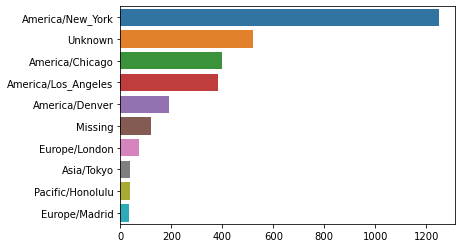

In [21]:
# Подсчёт часовых поясов с помощью pandas
import pandas as pd
frame=pd.DataFrame(records)
tz_counts=frame['tz'].value_counts()
# Подготовка к визуализации
clean_tz=frame['tz'].fillna('Missing')
clean_tz[clean_tz=='']='Unknown'
tz_counts=clean_tz.value_counts()
import seaborn as sns
subset=tz_counts[:10]
sns.barplot(y=subset.index, x=subset.values)

<AxesSubplot:xlabel='total', ylabel='tz'>

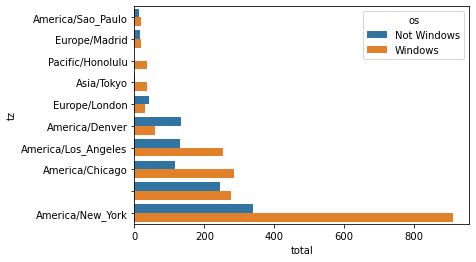

In [25]:
# Выделить пользоватей Windows
import numpy as np
cframe=frame[frame.a.notnull()]
cframe.index = np.arange(1, len(cframe) + 1)
cframe = cframe.copy()
cframe['os']=np.where(cframe['a'].str.contains('Windows'),
               'Windows','Not Windows')

# Сгруппировать
by_tz_os=cframe.groupby(['tz','os'])
# Групповые счётчики
agg_counts=by_tz_os.size().unstack().fillna(0)
# Выбрать первые 10 часовых поясов
indexer=agg_counts.sum(1).argsort()
count_subset=agg_counts.take(indexer)[-10:]
# Построить диаграмму
import seaborn as sns
count_subset=count_subset.stack()
count_subset.name='total'
count_subset=count_subset.reset_index()
sns.barplot(x='total',y='tz',hue='os',data=count_subset)

<AxesSubplot:xlabel='normed_total', ylabel='tz'>

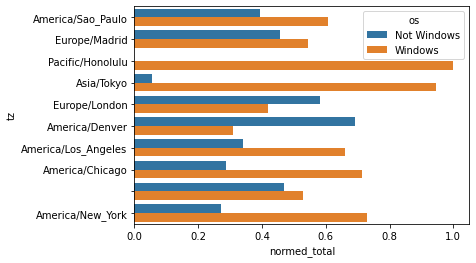

In [26]:
# Нормированная диаграмма
def norm_total(group):
    group['normed_total']=group.total/group.total.sum()
    return group
results=count_subset.groupby('tz').apply(norm_total)
sns.barplot(x='normed_total',y='tz',hue='os',data=results)

<AxesSubplot:>

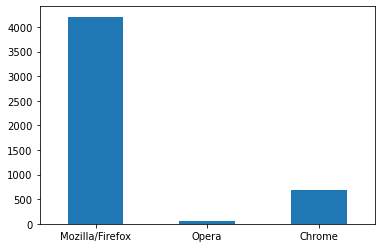

In [47]:
# Подсчёт браузеров
def CountBrowsers(sequence):
    MozillaCounter=0
    OperaCounter=0
    ChromeCounter=0
    for strings in sequence:
        MozillaCounter+=strings.count('Mozilla')
        MozillaCounter+=strings.count('Firefox')
        OperaCounter+=strings.count('Opera')
        ChromeCounter+=strings.count('Chrome')
    return MozillaCounter, OperaCounter, ChromeCounter

bframe=CountBrowsers(cframe['a'])

Browsers=pd.Series(bframe, index=['Mozilla/Firefox', 'Opera', 'Chrome'])
Browsers.plot.bar(rot=0)

<AxesSubplot:xlabel='total', ylabel='tz'>

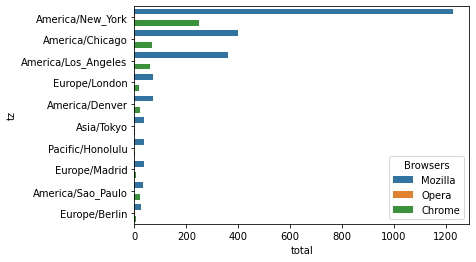

In [1]:
# Браузеры распространённые в таймзонах
path='datasets/bitly_usagov/example.txt'
import json
path='datasets/bitly_usagov/example.txt'
records=[json.loads(line) for line in open(path)]
import pandas as pd
frame=pd.DataFrame(records)
# Выделить пользоватей браузеров
import numpy as np
cframe=frame[frame.a.notnull()]
cframe = cframe.copy()
cframe.index = np.arange(1, len(cframe) + 1)
cframe['mbws']=np.where(cframe['a'].str.contains('Mozilla|Firefox'),
               'Mozilla','Not Mozilla')
cframe['obws']=np.where(cframe['a'].str.contains('Opera'),
               'Opera','Not Opera')
cframe['cbws']=np.where(cframe['a'].str.contains('Chrome'),
               'Chrome','Not Chrome')
# Сгруппировать
mby_tz=cframe.groupby(['tz', 'mbws'])
oby_tz=cframe.groupby(['tz', 'obws'])
cby_tz=cframe.groupby(['tz', 'cbws'])
# Групповые счётчики
magg_counts=mby_tz.size().unstack().fillna(0)
oagg_counts=oby_tz.size().unstack().fillna(0)
cagg_counts=cby_tz.size().unstack().fillna(0)
agg_counts=pd.merge(magg_counts, oagg_counts, on="tz")
agg_counts=pd.merge(agg_counts, cagg_counts, on="tz")
agg_counts=agg_counts.drop(['Not Mozilla', 'Not Opera', 'Not Chrome'], 1)
filt = agg_counts.index != ""
agg_counts=agg_counts[filt]
# Выбрать первые 10 часовых поясов
count_subset=agg_counts.nlargest(10, ['Mozilla', 'Opera', 'Chrome'])
# Построить диаграмму
import seaborn as sns
count_subset=count_subset.stack()
count_subset.name='total'
count_subset=count_subset.reset_index()
count_subset.rename(columns={'level_1': 'Browsers'}, inplace=True)
count_subset=count_subset.dropna(1)
sns.barplot(x='total',y='tz',hue='Browsers',data=count_subset)

<AxesSubplot:xlabel='normed_total', ylabel='tz'>

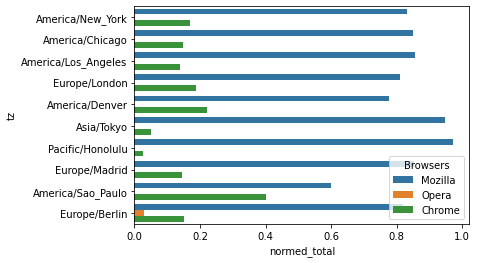

In [2]:
# Нормированная диаграмма
def norm_total(group):
    group['normed_total']=group.total/group.total.sum()
    return group
results=count_subset.groupby('tz').apply(norm_total)
sns.barplot(x='normed_total',y='tz',hue='Browsers',data=results)